In [ ]:
!pip install -q amplpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.7 MB/s eta 0:00:00


In [ ]:
from amplpy import AMPL, tools
ampl = tools.ampl_notebook(
    modules=["coin"],
    license_uuid="default")

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://ampl.com/colab).


In [ ]:
# Question 1
%%writefile Optimization.mod

# Sets of variables
set I={"K", "S"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0; # Decision variables from supply nodes to demand nodes

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j];

# Constraints
s.t. Capacity{i in I}: sum{j in J} x[i,j] = Cap[i]; # capacity constraints for each supply node
s.t. Demand{j in J}: sum{i in I} x[i,j] <= Dem[j]; # demand constraints for each demand node

Writing Optimization.mod


In [ ]:
%%writefile Optimization.dat

param Cap:=
K 60000
S 60000;

param Cost: T	H MC M L C A:=
K 1.79 2.13 1.76 2.34 1.86 1.9 1.82
S 2.13 2.03 1.58 1.8 2.14 1.26 1.76;

param Dem:=
T 5000
H 50000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Writing Optimization.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model Optimization.mod;
data Optimization.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 210570
0 simplex iterations
Z = 210570

x :=
K A    15000
K C        0
K H        0
K L    40000
K M        0
K MC       0
K T     5000
S A    45000
S C    10000
S H        0
S L        0
S M     1000
S MC    4000
S T        0
;



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = ampl.get_variable("x").get_values().to_pandas()
df.index = pd.MultiIndex.from_tuples(df.index, names=['Supplier', 'Distributor'])
df = df['x.val'].unstack()
df

Distributor,A,C,H,L,M,MC,T
Supplier,,,,,,,
K,15000,0,0,40000,0,0,5000
S,45000,10000,0,0,1000,4000,0


In [ ]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(df.index, bipartite=0)
G.add_nodes_from(df.columns, bipartite=1)
for source in df.index:
    for destination in df.columns:
        quantity = df.at[source, destination]
        if quantity > 0:
            G.add_edge(source, destination, weight=quantity)
pos = {node: (0, i) for i, node in enumerate(df.index)}
pos.update({node: (1, i) for i, node in enumerate(df.columns)})

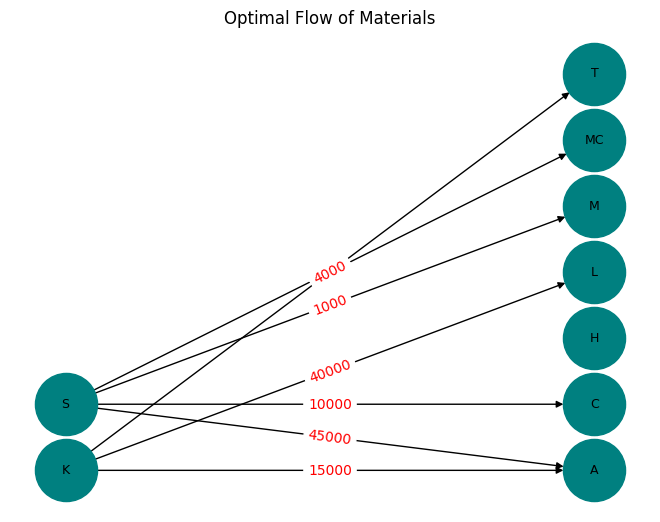

In [ ]:
labels = {node: node for node in G.nodes}

nx.draw(G, pos, with_labels=labels, font_weight='normal', node_size=2000, node_color='Teal', font_size=9, font_color='black', arrowsize=10, width=1)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos,   edge_labels=edge_labels, font_color='red')

plt.title('Optimal Flow of Materials')
plt.show()

In [ ]:
# Question 2
%%writefile CapacityExpansion.mod

# Sets of variables
set I={"K", "S"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0 integer; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param NewCap{I}; # new capacity parameter for each supply node if chosen
param NewCost{I}; # new fixed investment cost for each supply node if chosen

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*NewCost[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. NewCapacity{i in I}: sum{j in J} x[i,j] <= Cap[i] + NewCap[i]*y[i];

Overwriting CapacityExpansion.mod


In [ ]:
%%writefile CapacityExpansion.dat

param: Cap NewCap NewCost:=
K 60000 50000 2590000
S 60000 50000 2061000;

param Cost: T	H MC M L C A:=
K 1.79 2.13 1.76 2.34 1.86 1.9 1.82
S 2.13 2.03 1.58 1.8 2.14 1.26 1.76;

param Dem:=
T 5000
H 50000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Overwriting CapacityExpansion.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model CapacityExpansion.mod;
data CapacityExpansion.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 4972370
1 simplex iterations
1 barrier iterations
Z = 4972370

x :=
K A    20000
K C        0
K H        0
K L    40000
K M        0
K MC       0
K T     5000
S A    40000
S C    10000
S H    50000
S L        0
S M     6000
S MC    4000
S T        0
;



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = ampl.get_variable("x").get_values().to_pandas()
df.index = pd.MultiIndex.from_tuples(df.index, names=['Supplier', 'Distributor'])
df = df['x.val'].unstack()
df

Distributor,A,C,H,L,M,MC,T
Supplier,,,,,,,
K,20000,0,0,40000,0,0,5000
S,40000,10000,50000,0,6000,4000,0


In [ ]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(df.index, bipartite=0)
G.add_nodes_from(df.columns, bipartite=1)
for source in df.index:
    for destination in df.columns:
        quantity = df.at[source, destination]
        if quantity > 0:
            G.add_edge(source, destination, weight=quantity)
pos = {node: (0, i) for i, node in enumerate(df.index)}
pos.update({node: (1, i) for i, node in enumerate(df.columns)})

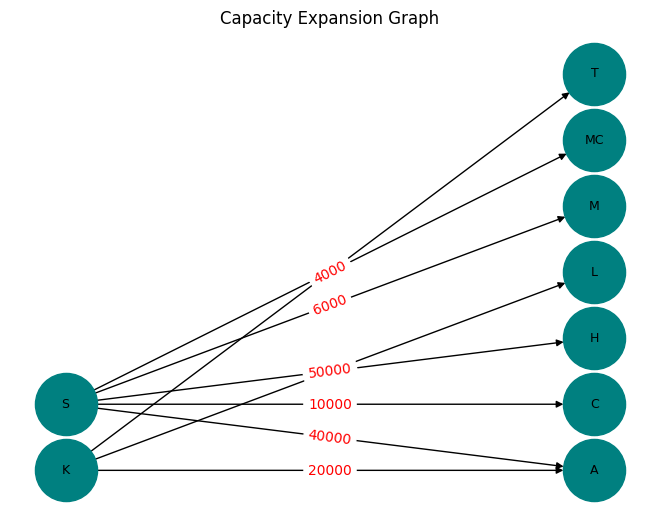

In [ ]:
labels = {node: node for node in G.nodes}

nx.draw(G, pos, with_labels=labels, font_weight='normal', node_size=2000, node_color='Teal', font_size=9, font_color='black', arrowsize=10, width=1)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos,   edge_labels=edge_labels, font_color='red')

plt.title('Capacity Expansion Graph')
plt.show()

In [ ]:
# Question 3
%%writefile NewPlants.mod

# Sets of variables
set I={"K", "S", "U", "B", "F", "I", "P"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0 integer; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param F{I}; # fixed costs for new supply nodes

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*F[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. Capacity{i in I}: sum{j in J} x[i,j] <= Cap[i]*y[i]; # capacity constraints for each supply node
s.t. KeepKS: y["K"] + y["S"] =2; # Keeping KC & S open

Overwriting NewPlants.mod


In [ ]:
%%writefile NewPlants.dat

param: Cap F:=
K 60000 0
S 60000 0
U 15000 917000
B 15000 962000
F 20000 1093000
I 25000 959000
P 20000 1058000;

param Cost: T H MC M L C A:=
K	1.79 2.13 1.76 2.34 1.86 1.9 1.82
S	2.13 2.03 1.58 1.8 2.14 1.26 1.76
U	1.86 1.18 1.5 0.91 1.98 1.54 1.74
B	1.34 1.6 1.29 1.52 1.47 1.37 1.02
F	1.52 1.65 1.54 1.73 1.37 1.59 1.42
I	1.67 1.21 1.56 1.38 1.44 1.61 1.57
P	1.71 1.44 1.72 1.43 1.88 1.5 1.73;

param Dem:=
T 5000
H 50000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Overwriting NewPlants.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model NewPlants.mod;
data NewPlants.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x, y;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 3114480
12 simplex iterations
12 barrier iterations
Z = 3114480

x [*,*]
:     A       C       H       L      M      MC     T      :=
B   15000       0       0       0      0      0      0
F       0       0       0       0      0      0      0
I       0       0   25000       0      0      0      0
K   15000       0       0   40000      0      0   5000
P       0       0       0       0      0      0      0
S   30000   10000   16000       0      0   4000      0
U       0       0    9000       0   6000      0      0
;

y [*] :=
B  1
F  0
I  1
K  1
P  0
S  1
U  1
;



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = ampl.get_variable("x").get_values().to_pandas()
df.index = pd.MultiIndex.from_tuples(df.index, names=['Supplier', 'Distributor'])
df = df['x.val'].unstack()
df

Distributor,A,C,H,L,M,MC,T
Supplier,,,,,,,
B,15000.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,25000.0,0.0,0.0,0.0,0.0
K,15000.0,0.0,0.0,40000.0,0.0,0.0,5000.0
P,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S,30000.0,10000.0,16000.0,0.0,0.0,4000.0,0.0
U,0.0,0.0,9000.0,0.0,6000.0,0.0,0.0


In [ ]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(df.index, bipartite=0)
G.add_nodes_from(df.columns, bipartite=1)
for source in df.index:
    for destination in df.columns:
        quantity = df.at[source, destination]
        if quantity > 0:
            G.add_edge(source, destination, weight=quantity)
pos = {node: (0, i) for i, node in enumerate(df.index)}
pos.update({node: (1, i) for i, node in enumerate(df.columns)})

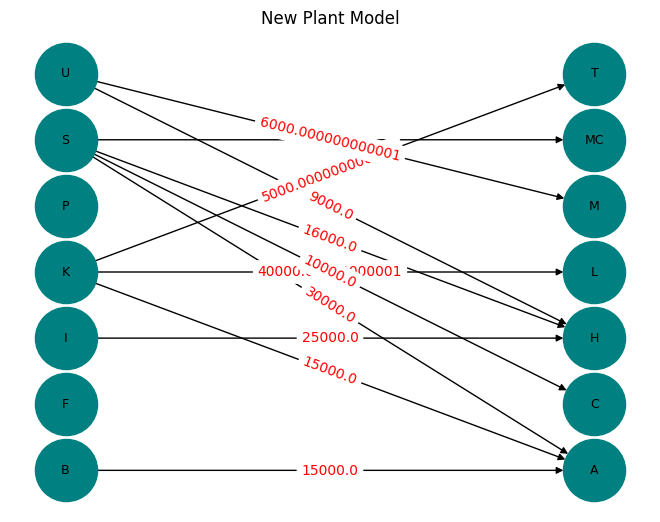

In [ ]:
labels = {node: node for node in G.nodes}

nx.draw(G, pos, with_labels=labels, font_weight='normal', node_size=2000, node_color='Teal', font_size=9, font_color='black', arrowsize=10, width=1)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos,   edge_labels=edge_labels, font_color='red')

plt.title('New Plant Model')
plt.show()

In [ ]:
# Question 4A
%%writefile Shanghai1.mod

# Sets of variables
set I={"K", "S"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param NewCap{I}; # new capacity parameter for each supply node if chosen
param NewCost{I}; # new fixed investment cost for each supply node if chosen

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*NewCost[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. NewCapacity{i in I}: sum{j in J} x[i,j] <= Cap[i] + NewCap[i]*y[i];

Writing Shanghai1.mod


In [ ]:
%%writefile Shanghai1.dat

param: Cap NewCap NewCost:=
K 60000 50000 2590000
S 60000 50000 2061000;

param Cost: T	H MC M L C A:=
K 1.79 2.13 1.76 2.34 1.86 1.9 1.82
S 2.13 2.03 1.58 1.8 2.14 1.26 1.76;

param Dem:=
T 5000
H 20000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Overwriting Shanghai1.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model Shanghai1.mod;
data Shanghai1.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 2320270
0 simplex iterations
Z = 2320270

x :=
K A        0
K C        0
K H        0
K L    40000
K M        0
K MC       0
K T     5000
S A    60000
S C    10000
S H    20000
S L        0
S M     6000
S MC    4000
S T        0
;



In [ ]:
# Question 4B
%%writefile Shanghai2.mod

# Sets of variables
set I={"K", "S"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param NewCap{I}; # new capacity parameter for each supply node if chosen
param NewCost{I}; # new fixed investment cost for each supply node if chosen

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*NewCost[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. NewCapacity{i in I}: sum{j in J} x[i,j] <= Cap[i] + NewCap[i]*y[i];

Writing Shanghai2.mod


In [ ]:
%%writefile Shanghai2.dat

param: Cap NewCap NewCost:=
K 60000 50000 2590000
S 60000 50000 2061000;

param Cost: T	H MC M L C A:=
K 1.79 2.13 1.76 2.34 1.86 1.9 1.82
S 2.13 2.03 1.58 1.8 2.14 1.26 1.76;

param Dem:=
T 5000
H 70000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Overwriting Shanghai2.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model Shanghai2.mod;
data Shanghai2.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 5014170
3 simplex iterations
3 barrier iterations
Z = 5014170

x :=
K A    40000
K C        0
K H        0
K L    40000
K M        0
K MC       0
K T     5000
S A    20000
S C    10000
S H    70000
S L        0
S M     6000
S MC    4000
S T        0
;



In [ ]:
# Question 4C
%%writefile Shanghai3.mod

# Sets of variables
set I={"K", "S"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param NewCap{I}; # new capacity parameter for each supply node if chosen
param NewCost{I}; # new fixed investment cost for each supply node if chosen

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*NewCost[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. NewCapacity{i in I}: sum{j in J} x[i,j] <= Cap[i] + NewCap[i]*y[i];

Writing Shanghai3.mod


In [ ]:
%%writefile Shanghai3.dat

param: Cap NewCap NewCost:=
K 60000 50000 2590000
S 60000 50000 2061000;

param Cost: T	H MC M L C A:=
K 1.79 2.13 1.76 2.34 1.86 1.9 1.82
S 2.13 2.03 1.58 1.8 2.14 1.26 1.76;

param Dem:=
T 5000
H 90000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Writing Shanghai3.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model Shanghai3.mod;
data Shanghai3.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 5055970
2 simplex iterations
2 barrier iterations
Z = 5055970

x :=
K A    60000
K C        0
K H        0
K L    40000
K M        0
K MC       0
K T     5000
S A       -1.31478e-11
S C    10000
S H    90000
S L        0
S M     6000
S MC    4000
S T        0
;



In [ ]:
# Question 4D
%%writefile Shanghai4.mod

# Sets of variables
set I={"K", "S", "U", "B", "F", "I", "P"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param F{I}; # fixed costs for new supply nodes

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*F[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. Capacity{i in I}: sum{j in J} x[i,j] <= Cap[i]*y[i]; # capacity constraints for each supply node
s.t. KeepKS: y["K"] + y["S"] =2; # Keeping KC & S open

Overwriting Shanghai4.mod


In [ ]:
%%writefile Shanghai4.dat

param: Cap F:=
K 60000 0
S 60000 0
U 15000 917000
B 15000 962000
F 20000 1093000
I 25000 959000
P 20000 1058000;

param Cost: T H MC M L C A:=
K	1.79 2.13 1.76 2.34 1.86 1.9 1.82
S	2.13 2.03 1.58 1.8 2.14 1.26 1.76
U	1.86 1.18 1.5 0.91 1.98 1.54 1.74
B	1.34 1.6 1.29 1.52 1.47 1.37 1.02
F	1.52 1.65 1.54 1.73 1.37 1.59 1.42
I	1.67 1.21 1.56 1.38 1.44 1.61 1.57
P	1.71 1.44 1.72 1.43 1.88 1.5 1.73;

param Dem:=
T 5000
H 20000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Writing Shanghai4.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model Shanghai4.mod;
data Shanghai4.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x, y;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 1200670
0 simplex iterations
Z = 1200670

x [*,*]
:     A       C       H       L      M      MC     T      :=
B       0       0       0       0      0      0      0
F       0       0       0       0      0      0      0
I       0       0   20000       0   5000      0      0
K   15000       0       0   40000      0      0   5000
P       0       0       0       0      0      0      0
S   45000   10000       0       0   1000   4000      0
U       0       0       0       0      0      0      0
;

y [*] :=
B  0
F  0
I  1
K  1
P  0
S  1
U  0
;



In [ ]:
# Question 4E
%%writefile Shanghai5.mod

# Sets of variables
set I={"K", "S", "U", "B", "F", "I", "P"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param F{I}; # fixed costs for new supply nodes

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*F[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. Capacity{i in I}: sum{j in J} x[i,j] <= Cap[i]*y[i]; # capacity constraints for each supply node
s.t. KeepKS: y["K"] + y["S"] =2; # Keeping KC & S open

Writing Shanghai5.mod


In [ ]:
%%writefile Shanghai5.dat

param: Cap F:=
K 60000 0
S 60000 0
U 15000 917000
B 15000 962000
F 20000 1093000
I 25000 959000
P 20000 1058000;

param Cost: T H MC M L C A:=
K	1.79 2.13 1.76 2.34 1.86 1.9 1.82
S	2.13 2.03 1.58 1.8 2.14 1.26 1.76
U	1.86 1.18 1.5 0.91 1.98 1.54 1.74
B	1.34 1.6 1.29 1.52 1.47 1.37 1.02
F	1.52 1.65 1.54 1.73 1.37 1.59 1.42
I	1.67 1.21 1.56 1.38 1.44 1.61 1.57
P	1.71 1.44 1.72 1.43 1.88 1.5 1.73;

param Dem:=
T 5000
H 70000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Overwriting Shanghai5.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model Shanghai5.mod;
data Shanghai5.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x, y;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 4201280
3 simplex iterations
3 barrier iterations
Z = 4201280

x [*,*]
:     A       C       H       L      M      MC     T      :=
B   15000       0       0       0      0      0      0
F       0       0       0       0      0      0      0
I       0       0   25000       0      0      0      0
K   15000       0       0   40000      0      0   5000
P       0       0   20000       0      0      0      0
S   30000   10000   16000       0      0   4000      0
U       0       0    9000       0   6000      0      0
;

y [*] :=
B  1
F  0
I  1
K  1
P  1
S  1
U  1
;



In [ ]:
# Question 4F
%%writefile Shanghai6.mod

# Sets of variables
set I={"K", "S", "U", "B", "F", "I", "P"}; # supply nodes
set J={"T", "H", "MC", "M", "L", "C", "A"}; # distribution/demand nodes

# Variables
var x{I,J} >=0; # Decision variables from supply nodes to demand nodes
var y{I} binary;

# Parameters
param Cap{I}; # capacity parameter for each supply node
param Cost{I, J}; # distribution costs from supply node to demand node
param Dem{J}; # demand parameter for each demand node
param F{I}; # fixed costs for new supply nodes

# Objective Function
# minimize costs

minimize Z: sum {i in I, j in J} Cost[i,j]*x[i,j] + sum {i in I} y[i]*F[i];

# Constraints
s.t. Demand{j in J}: sum{i in I} x[i,j] = Dem[j]; # demand constraints for each demand node
s.t. Capacity{i in I}: sum{j in J} x[i,j] <= Cap[i]*y[i]; # capacity constraints for each supply node
s.t. KeepKS: y["K"] + y["S"] =2; # Keeping KC & S open

Writing Shanghai6.mod


In [ ]:
%%writefile Shanghai6.dat

param: Cap F:=
K 60000 0
S 60000 0
U 15000 917000
B 15000 962000
F 20000 1093000
I 25000 959000
P 20000 1058000;

param Cost: T H MC M L C A:=
K	1.79 2.13 1.76 2.34 1.86 1.9 1.82
S	2.13 2.03 1.58 1.8 2.14 1.26 1.76
U	1.86 1.18 1.5 0.91 1.98 1.54 1.74
B	1.34 1.6 1.29 1.52 1.47 1.37 1.02
F	1.52 1.65 1.54 1.73 1.37 1.59 1.42
I	1.67 1.21 1.56 1.38 1.44 1.61 1.57
P	1.71 1.44 1.72 1.43 1.88 1.5 1.73;

param Dem:=
T 5000
H 90000
MC 4000
M 6000
L 40000
C 10000
A 60000;

Writing Shanghai6.dat


In [ ]:
%%ampl_eval

reset;

# Model File
model Shanghai6.mod;
data Shanghai6.dat;

# Calling Optimizaton Engine and Optimizing
option solver cbc;
solve;

# Display results
display Z, x, y;

cbc 2.10.10: cbc 2.10.10: optimal solution; objective 5326280
0 simplex iterations
Z = 5326280

x [*,*]
:     A       C       H       L      M      MC     T      :=
B   15000       0       0       0      0      0      0
F       0       0       0   20000      0      0      0
I       0       0   25000       0      0      0      0
K   35000       0       0   20000      0      0   5000
P       0       0   20000       0      0      0      0
S   10000   10000   36000       0      0   4000      0
U       0       0    9000       0   6000      0      0
;

y [*] :=
B  1
F  1
I  1
K  1
P  1
S  1
U  1
;

